# Глава 1. Полносвязные нейронные сети

## Часть 3. Примеры реальных задач

Три финансовые задачи:
1. Задача классификации (мошенничества с кредитными картами)
2. Задача регрессии (страховые потери)
3. Задача обучения без учителя с применением автоэнкодера (мошенничества с кредитными картами)

## 1. Задача классификации

* Набор данных, который мы собираемся использовать, можно скачать с Kaggle. 

* Он содержит данные об операциях с кредитными картами, которые произошли в течение двух дней, с 492 мошенничествами из 284 807 транзакций.

* Все переменные в наборе данных являются числовыми.

* Данные были преобразованы с использованием преобразования PCA по соображениям конфиденциальности. 

* Два признака, которые не были преобразованы, это Время и Сумма транзакции. Время содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
LABELS = ["Normal", "Fraud"]

In [3]:
df = pd.read_csv("datasets/creditcard.csv")

In [4]:
df.shape

(284807, 31)

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.isnull().values.any()

False

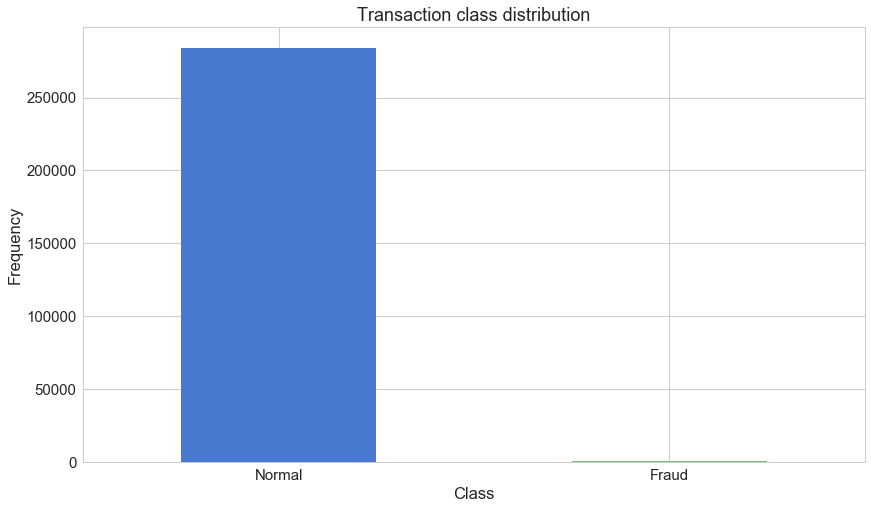

In [7]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [8]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [9]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

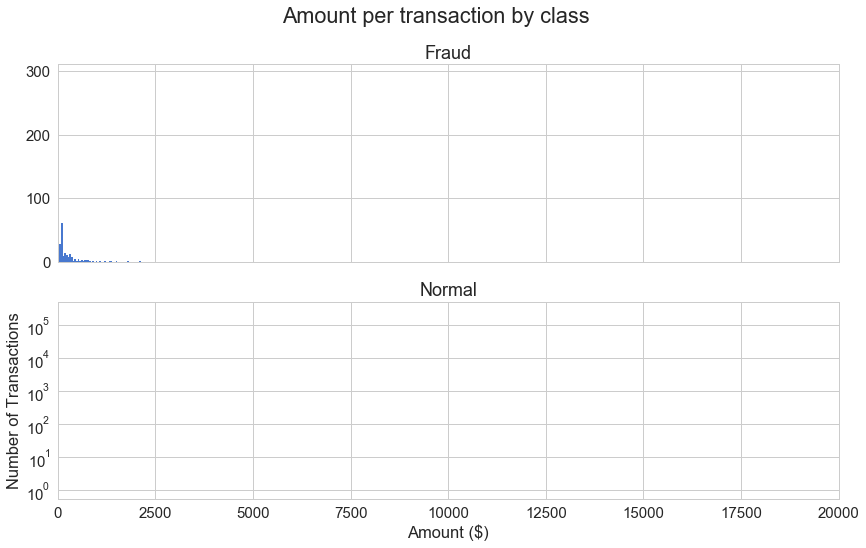

In [10]:
f = plt.figure(figsize=(20,10))
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

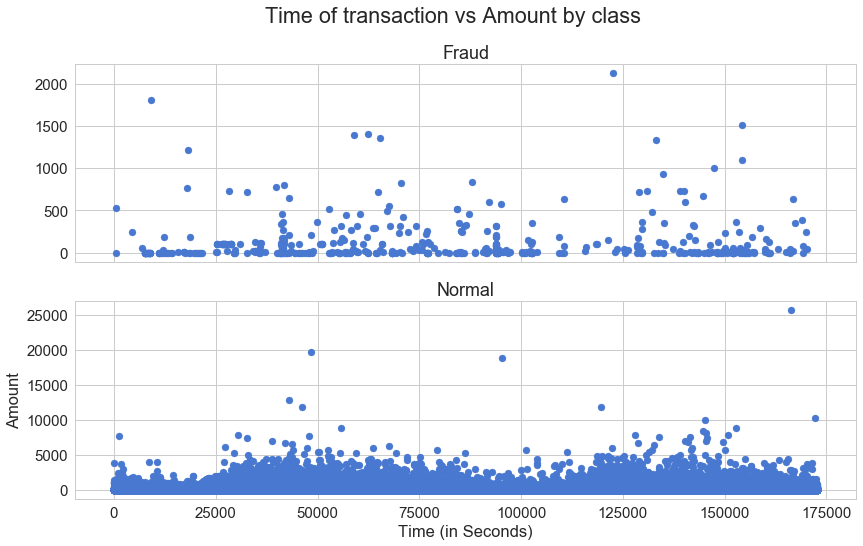

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [12]:
train, test = train_test_split(df, test_size = 0.2, stratify=df.Class)

In [13]:
x_train = train.iloc[:,1:30].values[:]
y_train = train['Class'].values[:]

x_test = test.iloc[:,1:30].values[:]
y_test = test['Class'].values[:]

print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

(227845, 29) (227845,)
(56962, 29) (56962,)


In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

### 1.3 Функция активации ReLU

ReLU является линейным для всех положительных значений и нулем для всех отрицательных значений. Это означает, что:

* Просто с вычислительной точки зрения. Таким образом, модели может потребоваться меньше времени для обучения.

* Быстрее сходимость. Линейность означает, что наклон не является плато или промежутком насыщения, когда x становится большим. 

* У ReLu нет проблемы исчезающего градиента, от которой страдают другие функции активации, такие как сигмоид или гиперболический тангес.

* Поскольку ReLU равен нулю для всех отрицательных входов. Производная также равна нулю. Бороться с этой проблемой, мы можем использовать негерметичный ReLU. Leaky ReLU гарантирует, что наклон для отрицательных значений не равен нулю.

![title](img/ann20.png)

### 1.4 Прореживание нейронной сети Dropout

**Переобучение (overfitting)** — одна из проблем глубоких нейронных сетей (Deep Neural Networks, DNN), состоящая в следующем: модель хорошо объясняет только примеры из обучающей выборки, адаптируясь к обучающим примерам, вместо того чтобы учиться классифицировать примеры, не участвовавшие в обучении (теряя способность к обобщению). 

* Главная идея Dropout — вместо обучения одной DNN обучить ансамбль нескольких DNN, а затем усреднить полученные результаты.

* Сети для обучения получаются с помощью исключения из сети (dropping out) нейронов с вероятностью , таким образом, вероятность того, что нейрон останется в сети, составляет . “Исключение” нейрона означает, что при любых входных данных или параметрах он возвращает 0.

* Исключенные нейроны не вносят свой вклад в процесс обучения ни на одном из этапов алгоритма обратного распространения ошибки (backpropagation); поэтому исключение хотя бы одного из нейронов равносильно обучению новой нейронной сети.

* В двух словах, Dropout хорошо работает на практике, потому что предотвращает взаимоадаптацию нейронов на этапе обучения.

![title](img/ann19.jpeg)

### 1.5 Методы оптимизации нейронных сетей

https://habr.com/ru/post/318970/

* Стохастический градиентный спуск (SGD)

* Nesterov Accelerated Gradient

* Adagrad

* RMSPROP и Adadelta

* Adam 

* Я бы предложил держать качестве метода оптимизации по умолчанию **Adam**, потому что он выдаёт наилучшие результаты при минимальном подгоне параметров. 
 
* Когда сеть уже более-менее отлажена, можно попробовать метод Нестерова с разными параметрами. Иногда с помощью него можно добиться лучших результатов, но он сравнительно чувствителен к изменениям в сети. Плюс-минус пара слоёв и нужно искать новый оптимальный learning rate.

* Рассматривайте остальные алгоритмы и их параметры как ещё несколько ручек и тумблеров, которые можно подёргать в каких-то специальных случаях.

### 1.6 Бинарная кросс-энтропия или Log Loss

![title](img/ann21.png)

![title](img/ann22.png)

Описание доступных функций потерь в Keras: https://keras.io/losses/
Как добавить свою метрику качества?

### 1.6 Keras Callbacks

Вызываемые функции в Keras

* **ModelCheckpoint**

Эта вызываемая функция сохранит вашу модель в виде файла контрольной точки (в формате hdf5) на диск после каждой успешной эпохи. Вы можете фактически установить выходной файл с динамическим именем в зависимости от эпохи. Вы также можете записать либо значение потерь, либо значение точности как часть имени файла журнала.

* **CSVLogger**

CSVLogger записывает файл истории в CSV, содержащий информацию об эпохах, точности и потерях на диск, чтобы вы могли проверить его позже.

* **EarlyStopping**

Одним из способов преодтвращения переобучения в нейронных сетях является использование ранней остановки. Ранняя остановка предотвращает переобучение вашей модели, прерывая процесс обучения, если процесс обучения более не улучшает обоющающую способность нейронной сети.

* **RemoteMonitor**

Этот возвращающая функция отправляет сообщения о состоянии в виде JSON через HTTP POST. Это может быть легко интегрировано со службой обмена сообщениями или с очередью, например Kafka, Amazon SQS и др.

* **LearningRateScheduler**

Другой метод оптимизации с глубоким обучением состоит в том, чтобы регулировать скорость обучения с течением времени. Скорость обучения определяет размером шагов градиентного спуска.

Один из методов - начать с относительно большого значения и уменьшать с увеличением эпох обучения. Все, что вам нужно сделать, это написать простую функцию, которая возвращает желаемую скорость обучения на основе текущей эпохи и передает ее в качестве параметра по расписанию (параметр schedule в callback LearningRateScheduler).

* **Tensorboard**

Это, пожалуй, самый крутой из всех стандартных callbacks. Используя callback TensorBoard, журналы будут записываться в каталог, который вы затем сможете просмотреть с помощью инструмента визуализации TensorBoard: кривые обучения, метрики качества и др.


In [16]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout

In [17]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(29,)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3840      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 12,625
Trainable params: 12,625
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(x_train, y_train,
                    batch_size=500,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 227845 samples, validate on 56962 samples
Epoch 1/50
227845/227845 [==============================] - 2s 8us/step - loss: 0.1144 - acc: 0.9799 - val_loss: 0.0287 - val_acc: 0.9983
Epoch 2/50
227845/227845 [==============================] - 2s 8us/step - loss: 0.0262 - acc: 0.9983 - val_loss: 0.0222 - val_acc: 0.9983
Epoch 3/50
227845/227845 [==============================] - 2s 8us/step - loss: 0.0197 - acc: 0.9983 - val_loss: 0.0156 - val_acc: 0.9983
Epoch 4/50
227845/227845 [==============================] - 2s 10us/step - loss: 0.0134 - acc: 0.9984 - val_loss: 0.0106 - val_acc: 0.9985
Epoch 5/50
227845/227845 [==============================] - 2s 8us/step - loss: 0.0102 - acc: 0.9986 - val_loss: 0.0094 - val_acc: 0.9988
Epoch 6/50
227845/227845 [==============================] - 2s 8us/step - loss: 0.0091 - acc: 0.9987 - val_loss: 0.0087 - val_acc: 0.9989
Epoch 7/50
227845/227845 [==============================] - 2s 8us/step - loss: 0.0082 - acc: 0.9989 - val_loss: 0.0083 

In [19]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.004896113240113387
Test accuracy: 0.9991748885221726


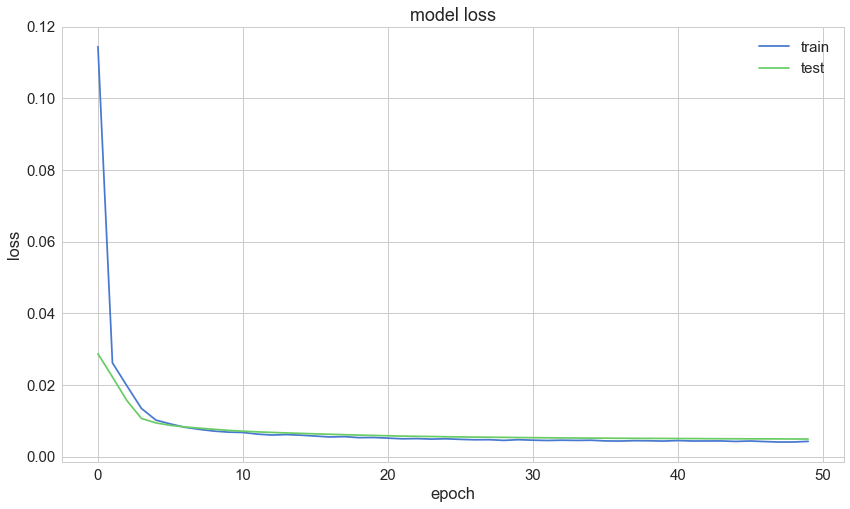

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [21]:
predictions = model.predict_proba(x_test)
y_pred = model.predict(x_test)
y_pred = (y_pred.flatten() > 0.5)*1
result_df = pd.DataFrame({'proba': predictions.flatten(), 'true_class': y_test})
result_df[result_df["true_class"]==1]

,proba,true_class
272,5.588297e-01,1
306,1.381634e-05,1
574,7.394229e-01,1
622,7.512324e-01,1
626,7.815337e-01,1
726,8.314874e-01,1
1648,2.037785e-02,1
2042,4.018822e-06,1
4377,4.257204e-06,1
5816,8.890179e-01,1


## 1.4. Кривая ROC. Площадь под ROC кривой - AUC ROC

In [22]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

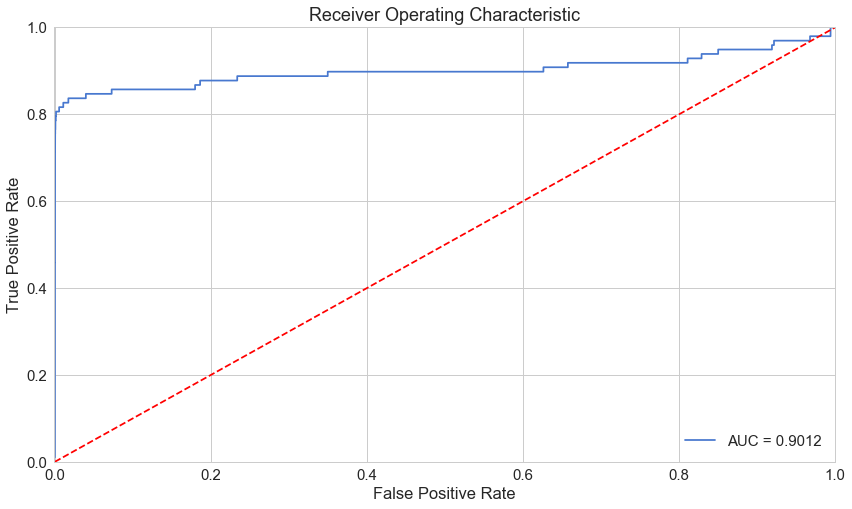

In [23]:
fpr, tpr, thresholds = roc_curve(result_df.true_class, result_df.proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## 1.5. Кривая точность-полнота (Precision-recall curve)

![title](img/ann15.png)

![title](img/ann17.png)

![title](img/ann18.png)

In [24]:
from sklearn.metrics import classification_report

In [25]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.80      0.69      0.74        98

avg / total       1.00      1.00      1.00     56962



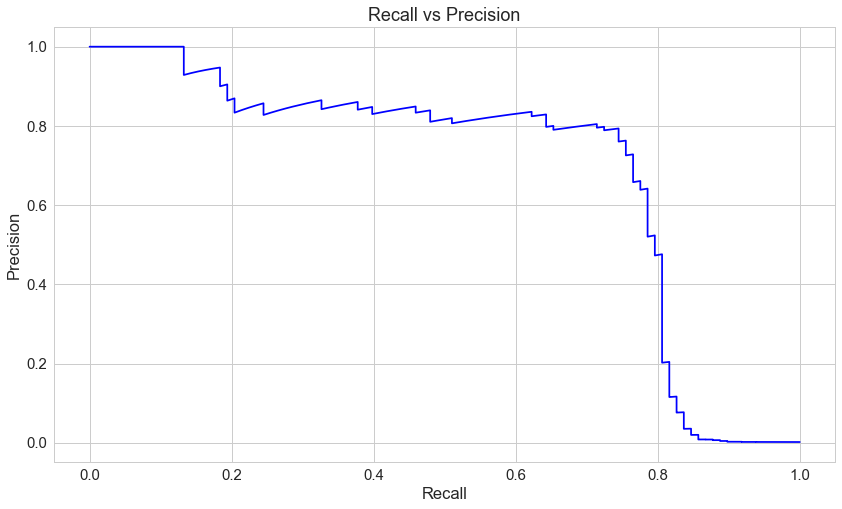

In [26]:
precision, recall, th = precision_recall_curve(result_df.true_class, result_df.proba)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## 2. Задача регрессии 

Предсказание страхового требования к Страховой компании AllState

Каждая строка в этом наборе данных представляет страховое требование. Вы должны предсказать значение для столбца «потери». Переменные, начинающиеся с 'cat', являются категориальными, тогда как переменные, начинающиеся с 'cont', являются непрерывными.

https://www.kaggle.com/c/allstate-claims-severity

In [27]:
from sklearn.feature_extraction import DictVectorizer

def prepare_data(data, train=True, dv=None):

    cat_keys = [k for k in data.keys() if k.startswith("cat")]
    cat_x = data[cat_keys]
    cont_keys = [k for k in data.keys() if k.startswith("cont")]
    cont_x = data[cont_keys]
    if train:
        y = data["loss"]
    else:
        y = None
    cat_x_dict = [r[1].to_dict() for r in cat_x.iterrows()]
    del cat_x
    if dv is None:
        dv = DictVectorizer().fit(cat_x_dict)
    cat_cont_x = dv.transform(cat_x_dict).toarray()
    del cat_x_dict
    return np.column_stack([cat_cont_x, cont_x]), y, dv

In [28]:
train_data = pd.read_csv("datasets/train.csv").set_index("id")
train_data.head(5)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
id,,,,,,,,,,,,,,,,,,,,,
1,A,B,A,B,A,A,A,A,B,A,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
2,A,B,A,A,A,A,A,A,B,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
5,A,B,A,A,B,A,A,A,B,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
10,B,B,A,B,A,A,A,A,B,A,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
11,A,B,A,B,A,A,A,A,B,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [29]:
print("Number of missing values", train_data.isnull().sum().sum())

Number of missing values 0


Целевая переменная перекошена (ассиметрия)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


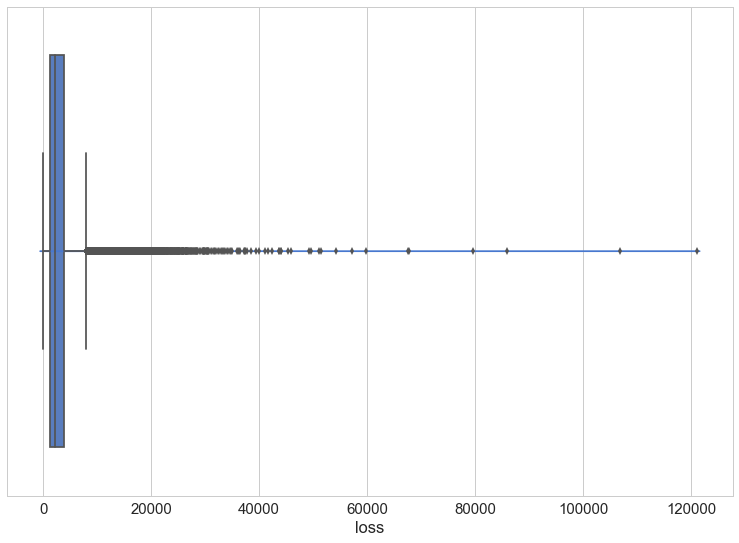

In [30]:
plt.figure(figsize=(13,9))
sns.distplot(train_data["loss"])
sns.boxplot(train_data["loss"])

Выглядит так, что распределение мы смогли нормализовать. Таким образом, мы будем использовать логарифм целевой переменной, потому что это дает возможность побороть выбросы

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


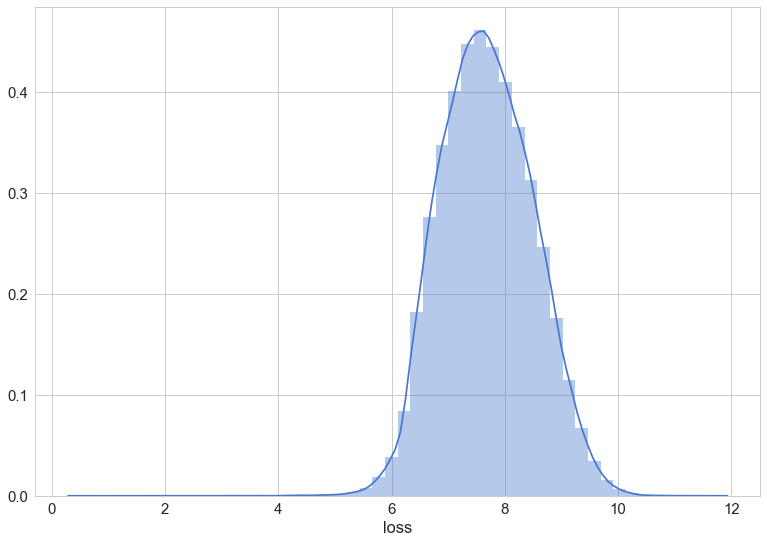

In [31]:
plt.figure(figsize=(13,9))
sns.distplot(np.log1p(train_data["loss"]))

In [32]:
train_x, train_y, dict_vec = prepare_data(train_data) 

In [33]:
test_data = pd.read_csv("datasets/test.csv").set_index("id")
test_x, _, _ = prepare_data(test_data, False, dict_vec)

In [34]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.objectives import MSE, MAE
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

seed=2019

In [35]:
def baseline_model():
    model = Sequential()
    model.add(Dense(input_dim=train_x.shape[1], output_dim=256))
    model.add(Activation("tanh"))
    model.add(Dropout(0.50))
    model.add(Dense(output_dim=128))
    model.add(Activation("relu"))
    model.add(Dropout(0.50))
    model.add(Dense(output_dim=64))
    model.add(Activation("relu"))
    model.add(Dropout(0.50))
    model.add(Dense(output_dim=1))
    model.compile(optimizer="Nadam", loss="mean_absolute_error")
    return model

10% на валидацию для контроля early stopping

In [36]:
model = baseline_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

train_log = model.fit(train_x, train_y.values, batch_size=256, nb_epoch=200, validation_split=0.1, 
                      verbose=2, callbacks=[early_stopping])

Train on 169486 samples, validate on 18832 samples
Epoch 1/200
 - 7s - loss: 1538.5450 - val_loss: 1206.6561
Epoch 2/200
 - 6s - loss: 1315.9137 - val_loss: 1190.8339
Epoch 3/200
 - 7s - loss: 1300.0486 - val_loss: 1165.2423
Epoch 4/200
 - 6s - loss: 1293.8589 - val_loss: 1313.0882
Epoch 5/200
 - 6s - loss: 1288.7241 - val_loss: 1286.7973
Epoch 6/200
 - 7s - loss: 1285.3991 - val_loss: 1241.5448
Epoch 7/200
 - 6s - loss: 1280.9498 - val_loss: 1172.5248
Epoch 8/200
 - 7s - loss: 1271.3808 - val_loss: 1171.2796
Epoch 9/200
 - 7s - loss: 1271.3553 - val_loss: 1173.5169
Epoch 10/200
 - 6s - loss: 1268.0341 - val_loss: 1167.0690
Epoch 11/200
 - 6s - loss: 1266.0731 - val_loss: 1189.7437
Epoch 12/200
 - 6s - loss: 1262.7325 - val_loss: 1168.0672
Epoch 13/200
 - 6s - loss: 1261.7753 - val_loss: 1151.1329
Epoch 14/200
 - 6s - loss: 1257.8543 - val_loss: 1162.7974
Epoch 15/200
 - 6s - loss: 1254.3167 - val_loss: 1154.5074
Epoch 16/200
 - 6s - loss: 1252.1714 - val_loss: 1172.0419
Epoch 17/200
 

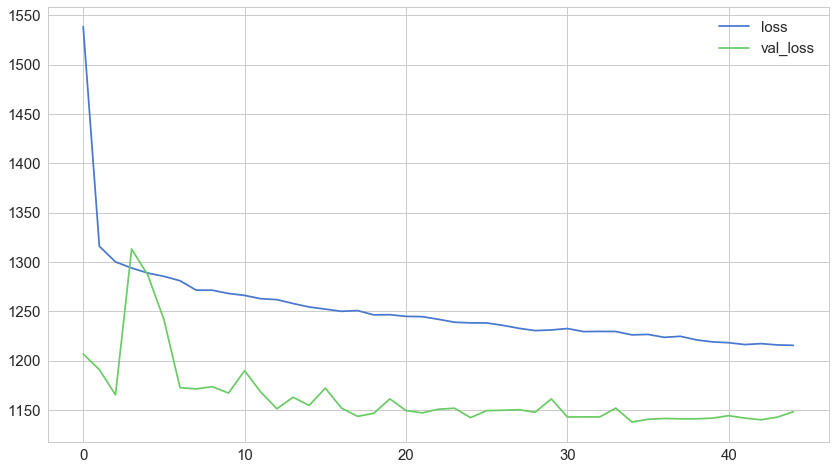

In [37]:
plt.plot(train_log.history["loss"], label="loss")
plt.plot(train_log.history["val_loss"], label="val_loss")
plt.legend()

In [38]:
pred_y = model.predict(test_x)
result = pd.DataFrame(pred_y, index=test_data.index, columns=["loss"])
result.to_csv("submission.csv")

## Кросс-валидация

In [39]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [40]:
seed=17
np.random.seed(seed)

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=5, batch_size=500, verbose=0)))
pipeline = Pipeline(estimators)

In [41]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, train_x, train_y, cv=kfold, scoring="neg_mean_absolute_error")
print("Metrics: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Metrics: -1196.32 (9.21) MSE


##  3. Задача классификации на основе нейросетевого автоэнкодера

* **Нейросетевой автоэнкодер** – алгоритм машинного обучения без учителя. 

* Основная идея автоэнкодера заключается в **уменьшении размерности** путем отображения исходного пространства признаков в латентное пространство меньшей размерности (этап кодирования), а затем в реконструкции входных данных на основе латентного представления (этап декодирования). 

* Сокращая размерность пространства, мы тем самым обучаем модель запоминать только наиболее важную информацию, из которой можно восстановить первоначальные данные. 

* Это свойство достигается путем формирования структуры кодировщика в виде «горлышка бутылки» (bottleneck), значительного уменьшая размерность последнего скрытого слоя. 

* Целью автоэнкодера является минимизация ошибки реконструкции между входными и выходными данными. Чтобы уменьшить ошибку реконструкции, в процессе обучения мы движемся в обратном направлении по нейронной сети и обновляем веса.

* Веса нейронов обновляются в зависимости от того, насколько они вносят вклад в ошибку реконструкции.

* Автоэнкодер можно рассматривать как алгоритм сжатия данных.

* Нейросетевой автоэнкодер захватывает нелинейные особенности данных, поэтому имеет преимущество перед PCA.

![title](img/ann12.png)

![title](img/ann13.png)

### 3.1. Ошибка реконструкции

Мы оптимизируем параметры нашей модели автоэнкодера таким образом, чтобы функция ошибки - ошибка реконструкции модели был сведен к минимуму. На практике часто используется традиционная среднеквадратичная ошибка:

![title](img/ann14.png)

### 3.2. Подготовка данных

Во-первых, давайте отбросим столбец Time (не собираюсь его использовать) и используем StandardScaler от Scikit на Amount. Масштабирующее устройство удаляет среднее значение и масштабирует значения до единичной дисперсии:

In [42]:
df = pd.read_csv("datasets/creditcard.csv")

In [43]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Обучение автоэнкодера несколько отличается от того, что мы наблюдали ранее. 

Допустим, у вас есть набор данных, содержащий множество не мошеннических транзакций. Вы хотите обнаружить любую аномалию в новых транзакциях. Мы создадим эту ситуацию, обучив нашу модель только обычным транзакциям. 

Резервирование правильного класса в тестовом наборе даст нам возможность оценить производительность нашей модели. Мы зарезервируем 20% наших данных для тестирования:

In [44]:
X_train, X_test = train_test_split(data, test_size=0.2, stratify=data.Class, random_state=seed)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 29)

### 3.3 Построение модели автоэнкодера

Построение модели
Наш Автоэнкодер использует 4 полностью связанных слоя с 14, 7, 7 и 29 нейронами соответственно. Первые два слоя используются для нашего кодера, последние два - для декодера. Кроме того, регуляризация L1 будет использоваться во время обучения:

In [45]:
input_dim = X_train.shape[1]
encoding_dim = 256 # 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Давайте обучим нашу модель 100 эпохам с размером партии 32 сэмпла и сохраним наиболее эффективную модель в файл. ModelCheckpoint, предоставляемый Keras, действительно удобен для таких задач. Кроме того, результаты обучения будут экспортированы в формате, понятном TensorBoard.

In [46]:
import keras.backend as K

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [47]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=[r2_score])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

AttributeError: module 'pandas.core.computation' has no attribute 'expressions'

In [ ]:
history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size,
                          shuffle=True, validation_data=(X_test, X_test), verbose=1, 
                          callbacks=[checkpointer, tensorboard]).history

In [ ]:
autoencoder = load_model('model.h5')

### 3.4 Оценка качества модели

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [ ]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

Кривые ROC являются очень полезным инструментом для понимания производительности двоичных классификаторов. Однако наш случай немного необычен. У нас очень несбалансированный набор данных. Тем не менее, давайте посмотрим на нашу кривую ROC:

Кривая ROC отображает истинную положительную частоту в сравнении с ложной положительной скоростью в зависимости от различных пороговых значений. По сути, мы хотим, чтобы синяя линия была как можно ближе к верхнему левому углу. В то время как наши результаты выглядят довольно хорошо, мы должны помнить о природе нашего набора данных. РПЦ не выглядит для нас очень полезным. Onward ...

In [ ]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

### 3.5 Кривая точности и полноты

In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Ошибка реконструкции растет, а рекол падает

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

### 4. Прогноз 

Чтобы предсказать, является ли новая / невидимая транзакция нормальной или мошеннической, мы рассчитаем ошибку реконструкции из данных транзакции. Если ошибка больше, чем предопределенный порог, мы помечаем ее как мошенническую(так как наша модель должна иметь низкую ошибку при обычных транзакциях). Давайте выберем это значение:

In [ ]:
threshold = 3.5

In [ ]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Наша модель ловит много мошеннических случаев. Однако есть и особенность. Модель имеет большое количество ложных срабатываний. 
Однако мы можем гибко варьировать порог и контролировать число обнаруживаемых в зависимости, например, от количества, которые мы можем обработать / проверить.

###  Задание 1.

Задача опредления вероятности дефолта (неуплаты долга) по кредитной карте

https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

* Постройте классификатор на основе полносвязной нейронной сети для определения вероятности дефолта по кредитной карте (невозврат долга).

* Экземляров данных довольно мало, поэтому не нужно упорствовать с увеличением глубины и ширины сети

* Обязательное кодирование категориальных признаков

* Обязательная стандартизация или масштабирование признаков

* Если применяете One Hot Encoding (бинарное кодирование), то обратите внимание на регуляризацию, чтобы предотвратить переобучение

* Постройте классификатор на основе автоэнкодера для решения этой же задачи аналогично примеру с мошенничествам по картам

Удачи!

In [1]:
import pandas as pd

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
